In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from mlxtend.feature_selection import SequentialFeatureSelector

import pickle

import warnings



import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

# Data

For our modeling approaches, certain models would require lagged data while other, time-series oriented models, would be able to use unlagged data.

As such we will load in two variants of our data:
- one unlagged dataset
- one where all features except 'est' and 'year' are lagged by 1 year

In [3]:
file_path = '../../src/data/temp/zbp_totals_with_features.csv'
data = pd.read_csv(file_path)

In [4]:
file_path = '../../src/data/temp/lagged_zbp_totals_with_features.csv'
lagged_data = pd.read_csv(file_path)

# Drop Categorical Flags

In [5]:
data = data.drop(columns=data.select_dtypes(exclude=['int64', 'float64']).columns)
lagged_data = lagged_data.drop(columns=lagged_data.select_dtypes(exclude=['int64', 'float64']).columns)

# Train-Test Split

Given our testing regimine, we will need two variants of each dataset
- Short-Term: Training [2012-2020], Testing [2021]
- Long-Term: Training [2012-2018], Testing [2019-2021]

In [6]:
def train_test_split_by_year(data, end_year):
    data_train = data[data['year'] <= end_year]
    data_test = data[data['year'] > end_year]
    return data_train, data_test

### Short-Term

In [7]:
end_year = 2020

short_data_train, short_data_test = train_test_split_by_year(data, end_year)
short_lagged_data_train, short_lagged_data_test = train_test_split_by_year(lagged_data, end_year)

### Long-Term

In [8]:
end_year = 2018

long_data_train, long_data_test = train_test_split_by_year(data, end_year)
long_lagged_data_train, long_lagged_data_test = train_test_split_by_year(lagged_data, end_year)

# Standardization

In [9]:
def standardize_data(data_train, data_test):
    train_mean = data_train.mean()
    train_mean['zip'] = 0
    train_std = data_train.std()
    train_std['zip'] = 1
    
    data_train_standardized = (data_train - train_mean) / train_std
    data_test_standardized = (data_test - train_mean) / train_std
    
    return data_train_standardized, data_test_standardized, (train_mean, train_std)

In [10]:
def unstandardize_series(ser, mean, std):
    return (ser*std)+mean

In [11]:
short_std_data_train, short_std_data_test, short_train_stats = standardize_data(short_data_train, short_data_test)
short_train_mean, short_train_std = short_train_stats

long_std_data_train, long_std_data_test, long_train_stats = standardize_data(long_data_train, long_data_test)
long_train_mean, long_train_std = long_train_stats

In [12]:
short_lagged_std_data_train, short_lagged_std_data_test, short_lagged_train_stats = standardize_data(short_lagged_data_train, short_lagged_data_test)
short_lagged_train_mean, short_lagged_train_std = short_lagged_train_stats

long_lagged_std_data_train, long_lagged_std_data_test, long_lagged_train_stats = standardize_data(long_lagged_data_train, long_lagged_data_test)
long_lagged_train_mean, long_lagged_train_std = long_lagged_train_stats

# One Hot Encoding

In [13]:
def convert_to_ohe(data_train, data_test):
    
    preproc = ColumnTransformer([('onehots', OneHotEncoder(handle_unknown='ignore'), ['zip'])]
                             ,remainder = 'passthrough')
    data_ohe_train = preproc.fit_transform(data_train)
    
    feature_names = preproc.get_feature_names_out()
    feature_names = np.char.replace(feature_names.astype('str'), 'onehots__','')
    feature_names = np.char.replace(feature_names, 'remainder__','')
    
    data_ohe_train = pd.DataFrame(data_ohe_train, columns=feature_names)
    
    data_ohe_test = preproc.transform(data_test)
    data_ohe_test = pd.DataFrame(data_ohe_test, columns=feature_names)
    
    return data_ohe_train, data_ohe_test

In [14]:
short_ohe_data_train, short_ohe_data_test = convert_to_ohe(short_std_data_train, short_std_data_test)
long_ohe_data_train, long_ohe_data_test = convert_to_ohe(long_std_data_train, long_std_data_test)

short_lagged_ohe_data_train, short_lagged_ohe_data_test = convert_to_ohe(short_lagged_std_data_train, short_lagged_std_data_test)
long_lagged_ohe_data_train, long_lagged_ohe_data_test = convert_to_ohe(long_lagged_std_data_train, long_lagged_std_data_test)

# Feature Selection

### Corr Matrix

In [15]:
top_k = 30
corr = short_lagged_ohe_data_train.corr()[['est']].sort_values(by='est', ascending=False)
vmin = corr.min()
vmax = corr.max()
corr_thresh = corr.abs().sort_values('est', ascending=False).iloc[top_k+2]['est']
corr = corr[corr['est'].abs() > corr_thresh]
# print(f'top {corr.shape[0]} features:')
display(corr[2:].style.background_gradient(cmap='coolwarm', vmin=vmin, vmax=vmax))
f'top {corr[2:].shape[0]} features by pearson correlation'

,est
emp,0.865098
ap,0.706980
qp1,0.701368
n20_49_pct,0.548041
naics_55_pct,0.519635
n50_99_pct,0.476420
zip_92101.0,0.463685
naics_51_pct,0.434940
n500_999_pct,0.419948
n100_249_pct,0.417339


'top 30 features by pearson correlation'

### Forward Feature Selection

In [16]:
X_train = short_lagged_ohe_data_train.drop(columns=['est'])
y_train = short_lagged_ohe_data_train['est']
X_test = short_lagged_ohe_data_test.drop(columns=['est'])
y_test = short_lagged_ohe_data_test['est']

ffs = SequentialFeatureSelector(LinearRegression(n_jobs=-1), k_features=top_k, forward=True, n_jobs=-1)
ffs.fit(X_train, y_train)
features = list(ffs.k_feature_names_)
features[::-1]

['est_lag_1',
 'total_midcareer (25-34)',
 'n500_999_pct',
 'n250_499_pct',
 'naics_61_pct',
 'naics_56_pct',
 'naics_54_pct',
 'naics_48_pct',
 'emp',
 'year',
 'zip_92154.0',
 'zip_92130.0',
 'zip_92124.0',
 'zip_92105.0',
 'zip_92101.0',
 'zip_92075.0',
 'zip_92058.0',
 'zip_92040.0',
 'zip_92037.0',
 'zip_92025.0',
 'zip_92020.0',
 'zip_92011.0',
 'zip_92010.0',
 'zip_92008.0',
 'zip_91977.0',
 'zip_91942.0',
 'zip_91941.0',
 'zip_91935.0',
 'zip_91932.0',
 'zip_91906.0']

# Models

In [17]:
def fit_eval(model, data_train, data_test, included_feats, train_mean, train_std):
    
    if included_feats == 'all':
        included_feats = data_train.columns.drop(['est'])
    
    X_train = data_train[included_feats]
    y_train = data_train['est']
    X_test = data_test[included_feats]
    y_test = data_test['est']
    
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_train)
    inverted_y_train = unstandardize_series(y_train, train_mean['est'], train_std['est'])
    inverted_y_preds = unstandardize_series(y_preds, train_mean['est'], train_std['est'])
    train_rmse = mean_squared_error(inverted_y_train, inverted_y_preds, squared=False)
    
    y_preds = model.predict(X_test)
    inverted_y_test = unstandardize_series(y_test, train_mean['est'], train_std['est'])
    inverted_y_preds = unstandardize_series(y_preds, train_mean['est'], train_std['est'])
    test_rmse = mean_squared_error(inverted_y_test, inverted_y_preds, squared=False)
    
    return model, train_rmse, test_rmse

In [18]:
all_features = 1

### Lin Reg

In [19]:
lr = LinearRegression(n_jobs=-1)

lr, train_rmse, test_rmse = fit_eval(lr, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                         'all', 
                                         short_lagged_train_mean, short_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  14.898629260500524
test_rmse:  21.50885415436945


In [20]:
lr = LinearRegression(n_jobs=-1)

lr, train_rmse, test_rmse = fit_eval(lr, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                         'all', 
                                         long_lagged_train_mean, long_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  14.622962945539763
test_rmse:  23.487200183737524


### Lasso

In [21]:
lasso = Lasso(alpha=0.007)

lasso, train_rmse, test_rmse = fit_eval(lasso, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                               'all', 
                                               short_lagged_train_mean, short_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  20.427570568913698
test_rmse:  22.681347283374723


In [22]:
lasso = Lasso(alpha=0.007)

lasso, train_rmse, test_rmse = fit_eval(lasso, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                               'all', 
                                               long_lagged_train_mean, long_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  20.515363262273645
test_rmse:  20.671181087487206


### Random Forest

In [23]:
rf = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=50, n_jobs=-1)

rf, train_rmse, test_rmse = fit_eval(rf, short_lagged_ohe_data_train, short_lagged_ohe_data_test, 
                                         'all', 
                                         short_lagged_train_mean, short_lagged_train_std)
print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  10.361644147742416
test_rmse:  38.800423537207315


In [24]:
rf = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=50, n_jobs=-1)

rf, train_rmse, test_rmse = fit_eval(rf, long_lagged_ohe_data_train, long_lagged_ohe_data_test, 
                                         'all', 
                                         long_lagged_train_mean, long_lagged_train_std)

print('train_rmse: ', train_rmse)
print('test_rmse: ', test_rmse)

train_rmse:  11.148166665420836
test_rmse:  48.99047961934379


array(['n5_9_pct', 'naics_11_pct', 'qp1', 'year',
       'total_midcareer (25-34)', 'naics_44_pct', 'zip_92121.0',
       'naics_61_pct', 'total_midcareer (35-44)', 'total_population',
       'naics_55_pct', 'naics_31_pct', 'n100_249_pct', 'naics_53_pct',
       'naics_51_pct', 'naics_42_pct', 'n1_4_pct', 'naics_48_pct',
       'n500_999_pct', 'ap', 'total_retirement', 'n250_499_pct',
       'zip_92101.0', 'naics_54_pct', 'median_hh_income', 'emp',
       'naics_62_pct', 'naics_81_pct', 'naics_72_pct'], dtype=object)

Text(0.5, 0, 'Mean decrease in impurity')

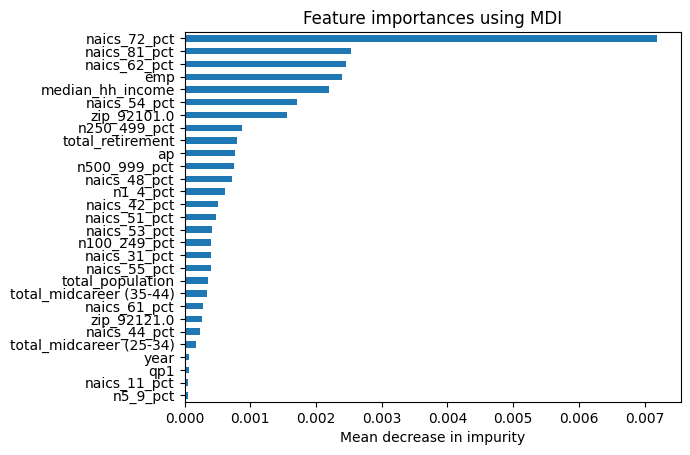

In [25]:
feature_names = short_lagged_ohe_data_train.columns.drop(['est'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[1:30].sort_values(ascending=True)
display(forest_importances.index.to_numpy())

fig, ax = plt.subplots()
forest_importances.plot(kind='barh', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")

### ARIMA

In [26]:
from statsmodels.tsa.arima.model import ARIMA

class ARIMAForecast():
    
    def __init__(self, data, n_lag_terms ,diff_order ,window_size):
        self.data = data
        self.models = {}
        self.n_lag_terms = n_lag_terms
        self.diff_order = diff_order
        self.window_size = window_size
        
    def train(self):
        for zip_code in self.data['zip'].unique():
            # filter
            curr_data = self.data[self.data['zip']==zip_code][['year', 'est']].set_index('year')
            start_time = curr_data.index[0]
            # train
            model = ARIMA(curr_data, order=(self.n_lag_terms ,self.diff_order ,self.window_size))
            try:
                results = model.fit()
                self.models[zip_code] = (results, start_time)
            except:
                pass
            
    def forecast(self, year):
        preds = []
        # last year seen in the training set
        # used to calculate start range for forecast, to avoid predicting values in training set
        data_last_year = self.data['year'].max()
        for zip_code, model_info in self.models.items():
            model, start_time = model_info
            # make predictions
            curr_pred = model.predict(data_last_year-start_time+1,year-start_time)
            # modify results into a df object
            curr_pred = curr_pred.to_frame().assign(zip=np.full(curr_pred.shape[0], zip_code)).reset_index()
            curr_pred = curr_pred.rename(columns={'index':'year', 0:'est', 'predicted_mean':'est'})
            # address issue where timestamp of some predictions is the number of years after the last year
            # in the training data rather than a timestamp object
            max_int = curr_pred[curr_pred['year'].apply(lambda x: type(x) == int)]['year'].max()
            curr_pred['year'] = curr_pred['year'].apply(lambda x: year-max_int+x if (type(x) == int) else x)
            preds += [curr_pred]
            
        return pd.concat(preds, ignore_index=True).reset_index(drop=True)
            

In [27]:
model = ARIMAForecast(short_data_train, 1, 1, 1)

model.train()

forecast = model.forecast(short_data_test['year'].max())
preds_labels = forecast.merge(short_data_test, on=['zip', 'year'], suffixes=('_pred', '_true'))

mean_squared_error(preds_labels['est_true'], preds_labels['est_pred'], squared=False)

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\s

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\s

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

21.86010421984797

In [28]:
model = ARIMAForecast(long_data_train, 1, 1, 1)

model.train()

forecast = model.forecast(long_data_test['year'].max())
preds_labels = forecast.merge(long_data_test, on=['zip', 'year'], suffixes=('_pred', '_true'))

mean_squared_error(preds_labels['est_true'], preds_labels['est_pred'], squared=False)

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\s

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\s

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maximilian Wei\anaconda3\envs\d

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maximilian Wei\anaconda3\envs\dsc180-capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

33.468354257232015

# LSTM

#### Windowing

In [29]:
class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift,
                train_df=long_ohe_data_train, test_df=long_ohe_data_test,
                label_columns=None, batch_size=1):
        
        self.batch_size = batch_size
        
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [30]:
def split_window(self, features):
    
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [32]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.example = example

In [33]:
def plot(self, model=None, plot_col='est', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [34]:
IN_STEPS = 1
OUT_STEPS = 1

single_step_window = WindowGenerator(input_width=IN_STEPS,
                                    label_width=OUT_STEPS,
                                    shift=OUT_STEPS,
                                    label_columns=['est'],
                                    batch_size=1)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['est']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (1, 1, 129)
Labels shape (batch, time, features): (1, 1, 1)


In [86]:
wide_window = WindowGenerator(input_width=5,
                              label_width=5,
                              shift=1,
                              label_columns=['est'],
                              batch_size=1)
wide_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [1 2 3 4 5]
Label column name(s): ['est']

#### Splitting Data into ZIP Codes

In [37]:
def split_by_zip_code(data_train, data_test, window):
    
    data_train_by_zc_tf = {}
    for zip_code in data_train.filter(like='zip').columns:
        data_by_zc = data_train[data_train[zip_code]==1]
        data_train_by_zc_tf[zip_code] = window.make_dataset(data_by_zc)
        
    data_test_by_zc_tf = {}
    for zip_code in data_test.filter(like='zip').columns:
        data_by_zc = data_test[data_test[zip_code]==1]
        data_test_by_zc_tf[zip_code] = window.make_dataset(data_by_zc)
        
    return data_train_by_zc_tf, data_test_by_zc_tf

In [38]:
long_data_train_by_zc_tf, long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, single_step_window)

In [39]:
wide_long_data_train_by_zc_tf, wide_long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, wide_window)

### Baseline

In [40]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [109]:
def evaluate_on_all_zip(model, data_train_by_zc):
    total = 0
    i = 0
    for zc in data_train_by_zc.keys():
        total += unstandardize_series(model.evaluate(data_train_by_zc[zc], verbose=0)[0], 
                                      long_train_mean['est'], long_train_std['est'])
        i += 1
    return np.sqrt(total/i)

In [42]:
column_indices = {name: i for i, name in enumerate(long_ohe_data_train.columns)}

baseline = Baseline(label_index=column_indices['est'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.losses.MeanSquaredError()])

evaluate_on_all_zip(baseline, long_data_train_by_zc_tf)

29.93518410743642

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (1, 5, 129)
Output shape: (1, 5, 1)


In [148]:
def wide_plot_model(model, wide_data, window):
    inputs, labels = next(iter(wide_data['zip_91915.0']))

    plt.figure(figsize=(12, 8))
    plot_col_index = window.column_indices['est']

    plt.ylabel(f'est [normed]')
    plt.plot(window.input_indices, inputs[0, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if window.label_columns:
        label_col_index = window.label_columns_indices.get('est', None)
    else:
        label_col_index = plot_col_index

    plt.scatter(window.label_indices, labels[0, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    predictions = model(inputs)
    print(predictions[0, :, label_col_index])
    plt.scatter(window.label_indices, predictions[0, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

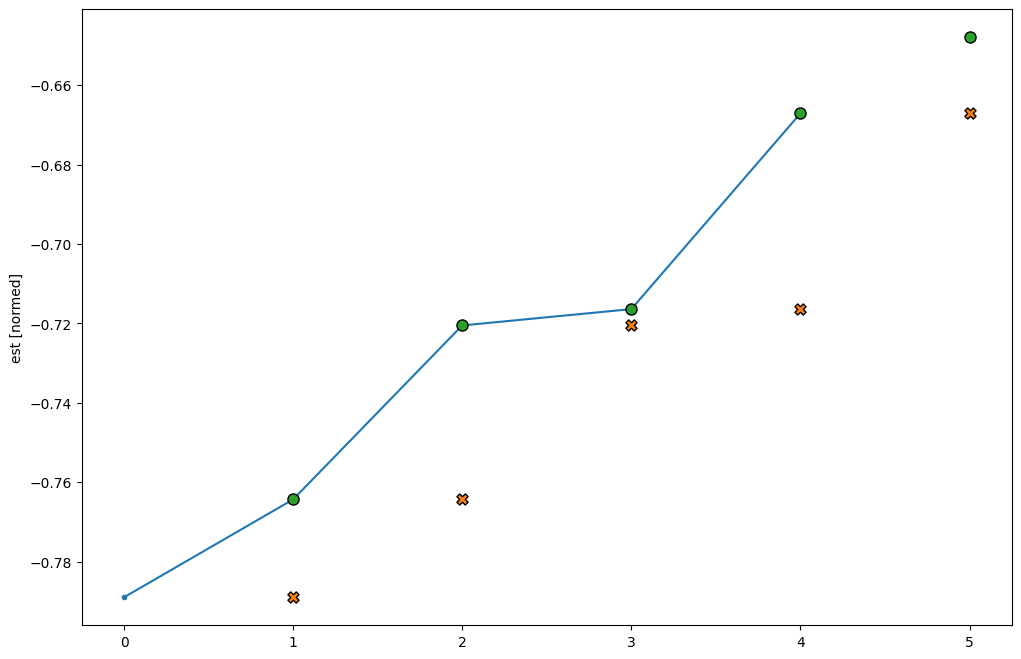

In [46]:
wide_plot_model(baseline, wide_long_data_train_by_zc_tf, wide_window)

#### Linear

In [47]:
def compile_and_fit(model, data_train_by_zc, data_test_by_zc, num_epochs):
    
    KERAS_VERBOSITY = 0

    losses = []
    val_losses = []

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.losses.MeanSquaredError()])
    
    for epoch in tqdm(np.arange(num_epochs)):
        
        loss_curr_epoch = 0
        val_loss_curr_epoch = 0
        i = 0
        
        data_train_by_zip = list(data_train_by_zc.values())
        data_test_by_zip = list(data_test_by_zc.values())
        
        for i in np.arange(len(data_train_by_zip)):
            
            history = model.fit(data_train_by_zip[i], epochs=1, validation_data=data_train_by_zip[i], verbose=KERAS_VERBOSITY)
            loss_curr_epoch += history.history['loss'][0]
            val_loss_curr_epoch += history.history['val_loss'][0]
            i += 1
                
        losses += [np.sqrt(unstandardize_series(loss_curr_epoch/i, long_train_mean['est'], long_train_std['est']))]
        val_losses += [np.sqrt(unstandardize_series(val_loss_curr_epoch/i, long_train_mean['est'], long_train_std['est']))]
                
    return losses, val_losses

In [48]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [49]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (1, 1, 129)
Output shape: (1, 1, 1)


In [50]:
losses, val_losses = compile_and_fit(linear, long_data_train_by_zc_tf, long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [06:38<00:00, 19.92s/it]


In [51]:
evaluate_on_all_zip(linear, long_data_train_by_zc_tf)

30.01239511169287

In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (1, 5, 129)
Output shape: (1, 5, 1)


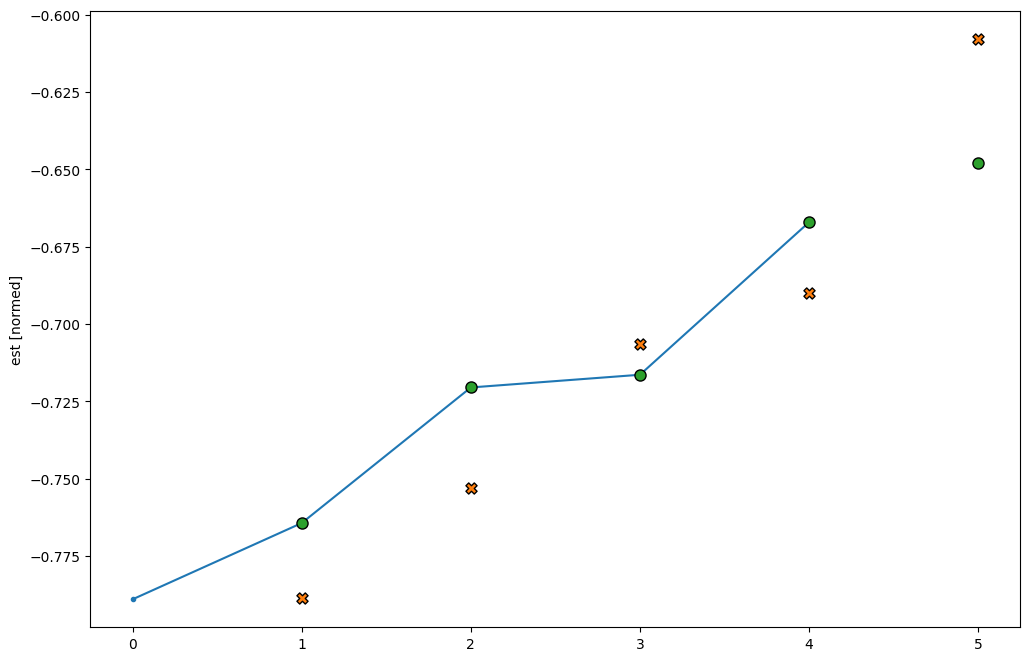

In [113]:
wide_plot_model(linear, wide_long_data_train_by_zc_tf, wide_window)

### Dense

In [54]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [55]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', dense(single_step_window.example[0]).shape)

Input shape: (1, 1, 129)
Output shape: (1, 1, 1)


In [56]:
losses, val_losses = compile_and_fit(dense, long_data_train_by_zc_tf, long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [08:08<00:00, 24.41s/it]


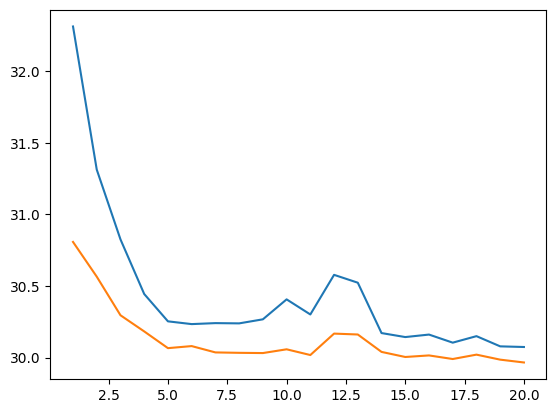

In [57]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')

In [58]:
evaluate_on_all_zip(dense, long_data_train_by_zc_tf)

30.35463369939157

In [59]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', dense(wide_window.example[0]).shape)

Input shape: (1, 5, 129)
Output shape: (1, 5, 1)


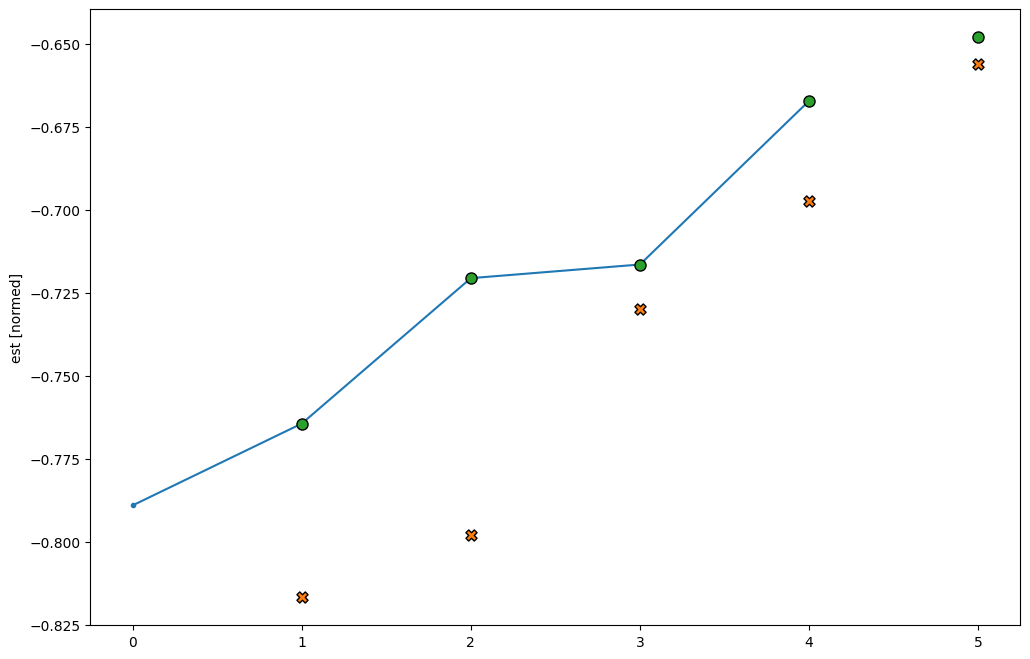

In [60]:
wide_plot_model(dense, wide_long_data_train_by_zc_tf, wide_window)

### CNN

In [61]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['est'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['est']

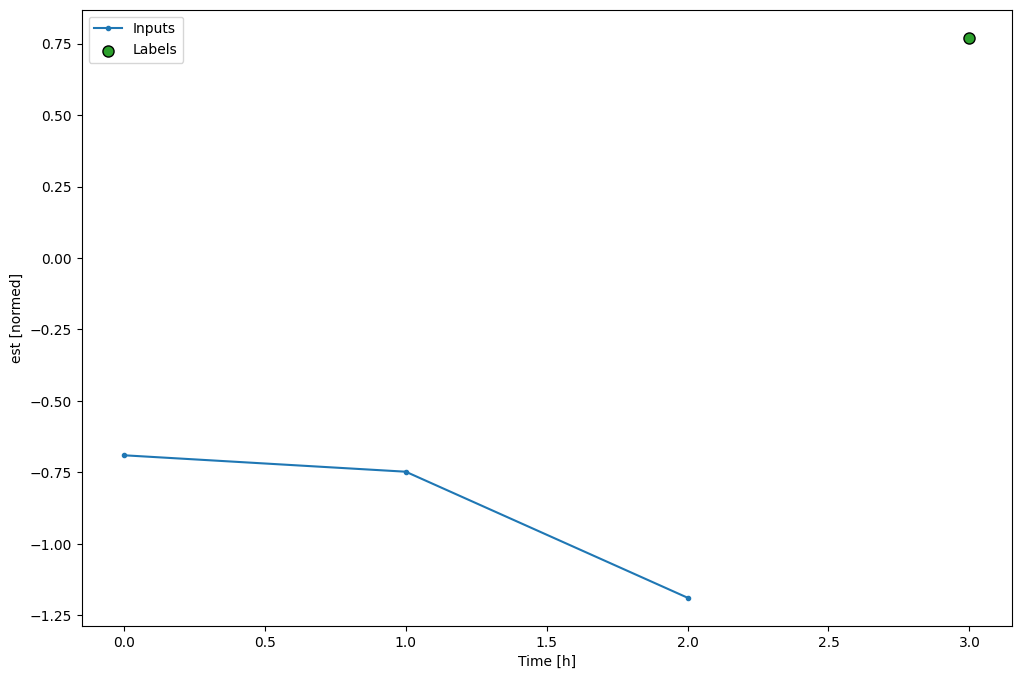

In [62]:
conv_window.plot()

In [63]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (1, 3, 129)
Output shape: (1, 1, 1)


In [64]:
conv_long_data_train_by_zc_tf, conv_long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, conv_window)

In [65]:
losses, val_losses = compile_and_fit(conv_model, conv_long_data_train_by_zc_tf, conv_long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [07:55<00:00, 23.78s/it]


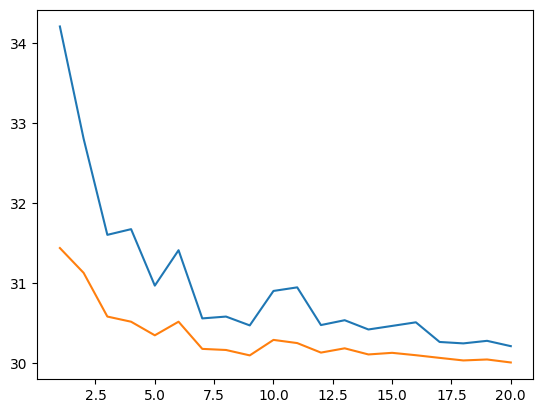

In [66]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')

In [69]:
LABEL_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['est'])

wide_conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [3 4 5]
Label column name(s): ['est']

In [70]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (1, 5, 129)
Labels shape: (1, 3, 1)
Output shape: (1, 3, 1)


In [71]:
wide_conv_long_data_train_by_zc_tf, wide_conv_long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, wide_conv_window)

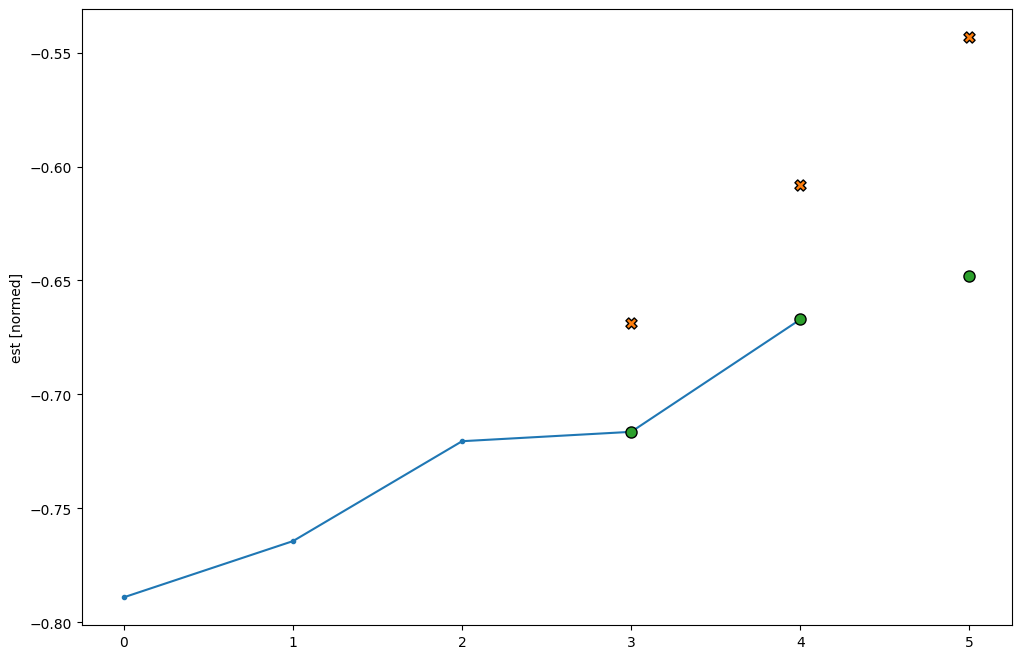

In [72]:
wide_plot_model(conv_model, wide_conv_long_data_train_by_zc_tf, wide_conv_window)

### RNN

In [94]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [95]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (1, 5, 129)
Output shape: (1, 5, 1)


In [96]:
losses, val_losses = compile_and_fit(lstm_model, wide_long_data_train_by_zc_tf, wide_long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [05:06<00:00, 15.33s/it]


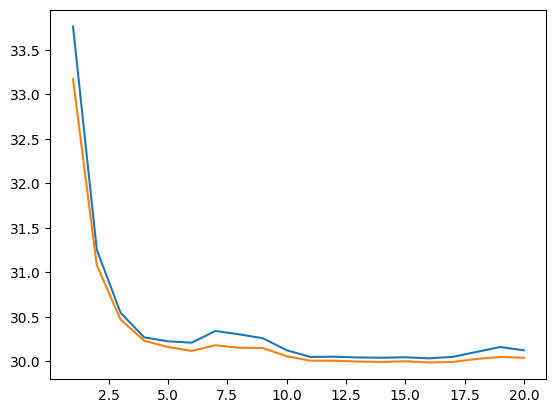

In [97]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')

In [104]:
evaluate_on_all_zip(lstm_model, wide_long_data_train_by_zc_tf)

30.315818926499485

In [99]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (1, 5, 129)
Output shape: (1, 5, 1)


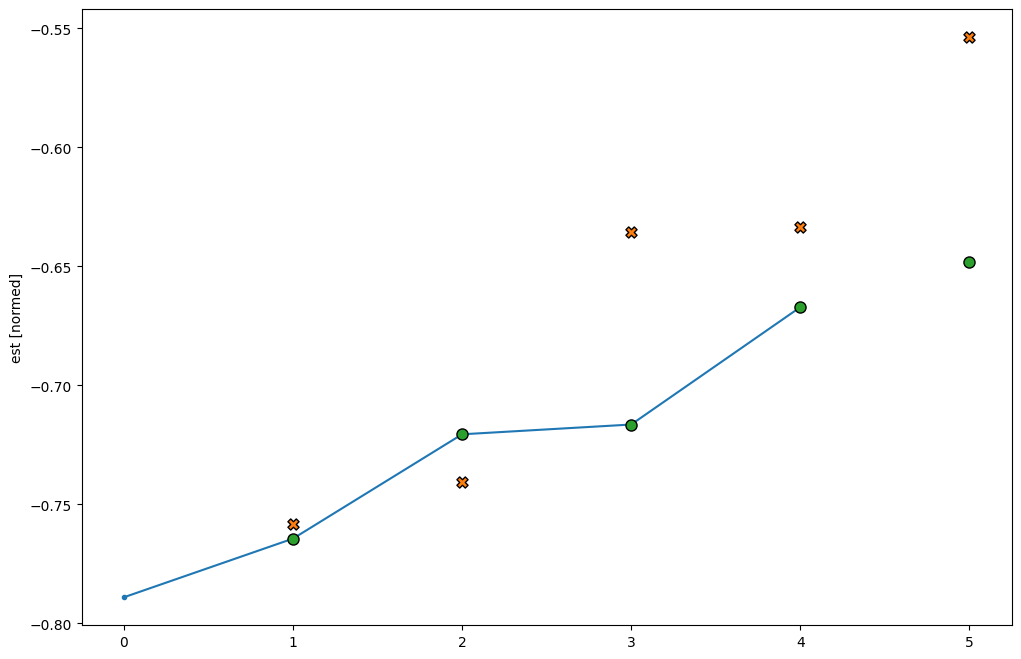

In [101]:
wide_plot_model(lstm_model, wide_long_data_train_by_zc_tf, wide_window)

In [125]:
uni_wide_window = WindowGenerator(input_width=1,
                              label_width=1,
                              shift=1,
                              label_columns=['est'],
                              batch_size=1)
uni_wide_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['est']

In [126]:
uni_wide_long_data_train_by_zc_tf, uni_wide_long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, uni_wide_window)

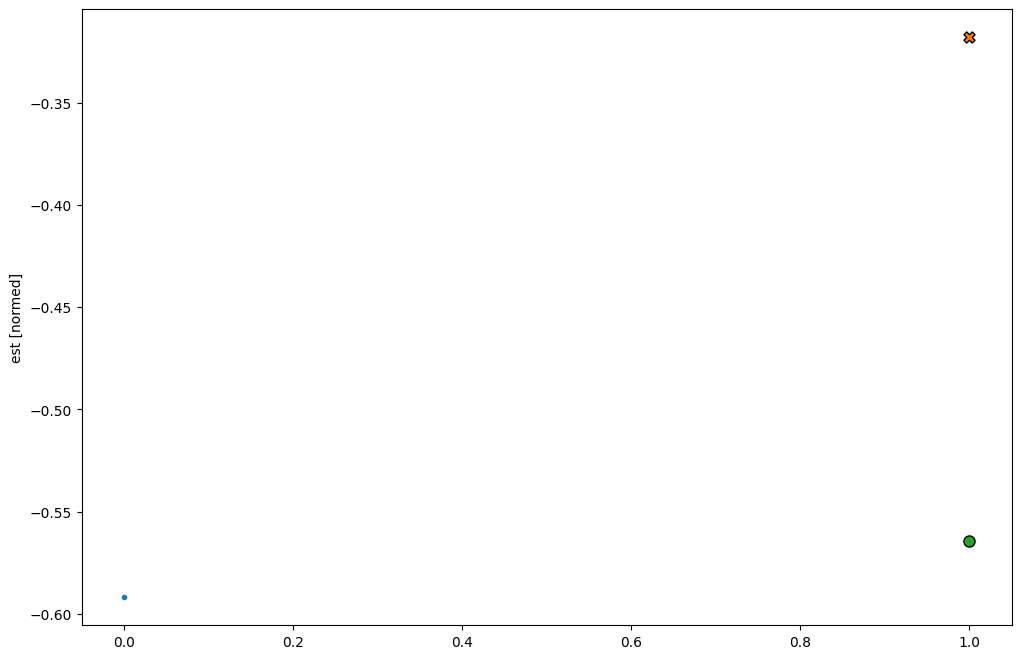

In [128]:
wide_plot_model(lstm_model, uni_wide_long_data_test_by_zc_tf, uni_wide_window)

# MultiStep Models

Total window size: 6
Input indices: [0 1 2]
Label indices: [3 4 5]
Label column name(s): None

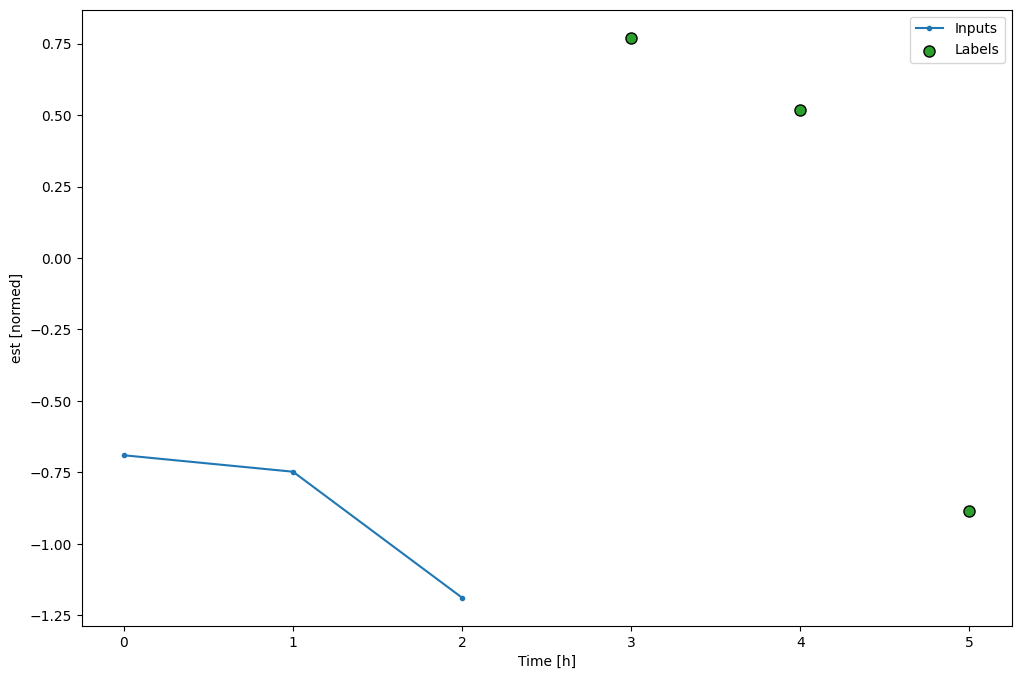

In [140]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_wide_long_data_train_by_zc_tf, multi_wide_long_data_test_by_zc_tf = split_by_zip_code(long_ohe_data_train, long_ohe_data_test, multi_window)
multi_window

#### Linear

In [150]:
num_features = long_ohe_data_train.shape[1]

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [151]:
losses, val_losses = compile_and_fit(multi_linear_model, multi_wide_long_data_train_by_zc_tf, multi_wide_long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [04:29<00:00, 13.47s/it]


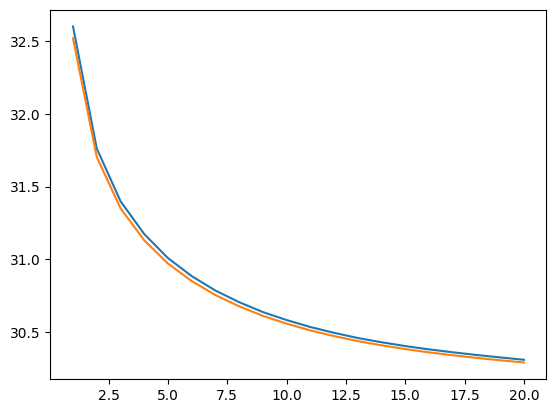

In [152]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')

In [153]:
evaluate_on_all_zip(multi_linear_model, multi_wide_long_data_train_by_zc_tf)

30.28748069638811

In [154]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_linear_model(multi_window.example[0]).shape)

Input shape: (1, 3, 129)
Output shape: (1, 3, 129)


tf.Tensor([-0.7270769 -0.7036045 -0.6783823], shape=(3,), dtype=float32)


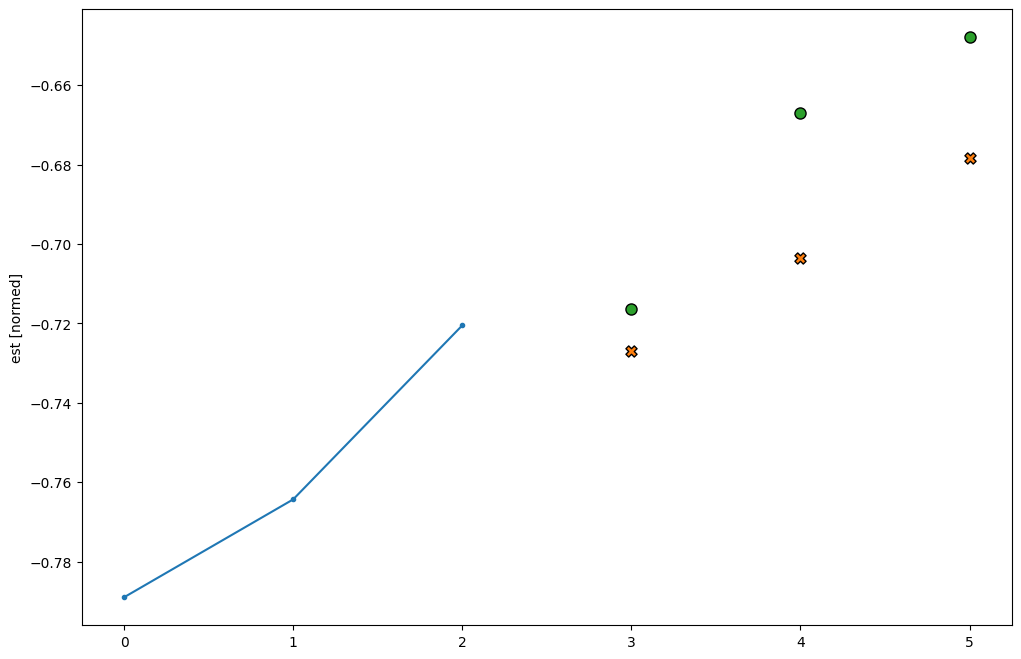

In [155]:
wide_plot_model(multi_linear_model, multi_wide_long_data_train_by_zc_tf, multi_window)

### Autoregressive LSTM

In [230]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [231]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [232]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [233]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [234]:
losses, val_losses = compile_and_fit(feedback_model, multi_wide_long_data_train_by_zc_tf, multi_wide_long_data_test_by_zc_tf, 20)

100%|██████████| 20/20 [05:54<00:00, 17.71s/it]


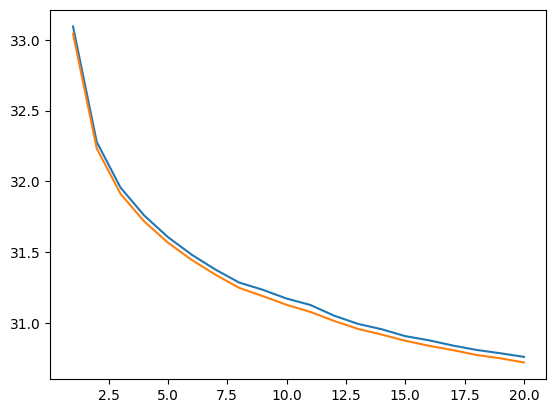

In [235]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')

In [236]:
evaluate_on_all_zip(feedback_model, multi_wide_long_data_train_by_zc_tf)

30.76638977787041

In [237]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', feedback_model(multi_window.example[0]).shape)

Input shape: (1, 3, 129)
Output shape: (1, 3, 129)


tf.Tensor([-0.4790952  -0.40316004 -0.35934007], shape=(3,), dtype=float32)


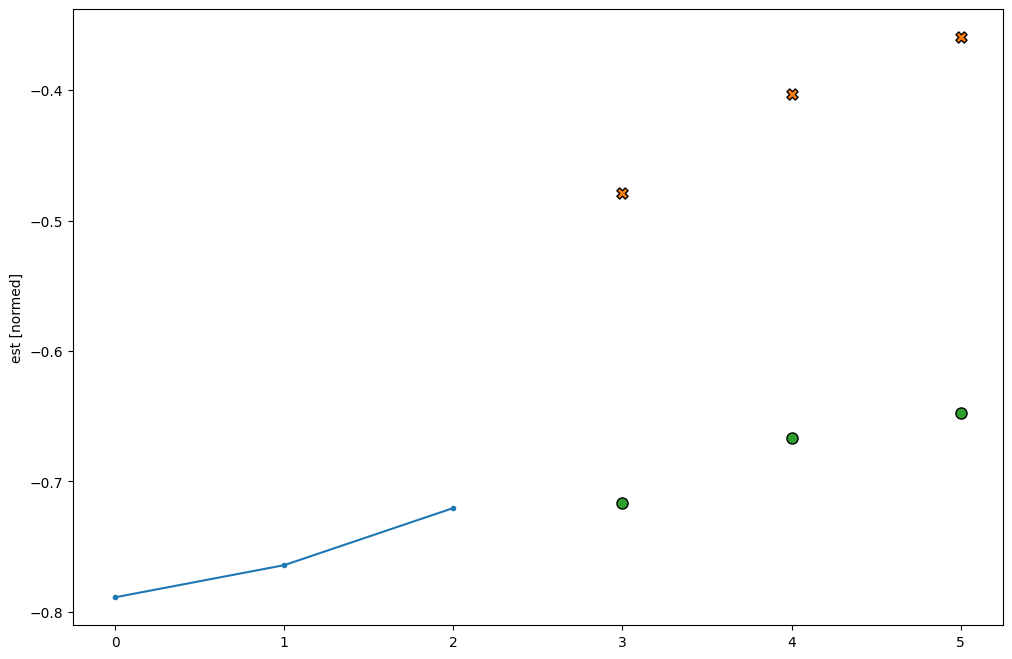

In [238]:
wide_plot_model(feedback_model, multi_wide_long_data_train_by_zc_tf, multi_window)

In [268]:
def auto_wide_plot_model(model, wide_data, window, extra_steps):
    inputs, labels = next(iter(wide_data['zip_91915.0']))

    plt.figure(figsize=(12, 8))
    plot_col_index = window.column_indices['est']

    plt.ylabel(f'est [normed]')
    plt.plot(window.input_indices, inputs[0, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if window.label_columns:
        label_col_index = window.label_columns_indices.get('est', None)
    else:
        label_col_index = plot_col_index

    plt.scatter(window.label_indices, labels[0, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    model.out_steps += extra_steps
    predictions = model(inputs, training=False)
    model.out_steps -= extra_steps
    new_pred_indicies = np.append(multi_window.label_indices, np.arange(multi_window.label_indices[-1] + 1, multi_window.label_indices[-1] + 1 + extra_steps))
    plt.scatter(new_pred_indicies, predictions[0, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

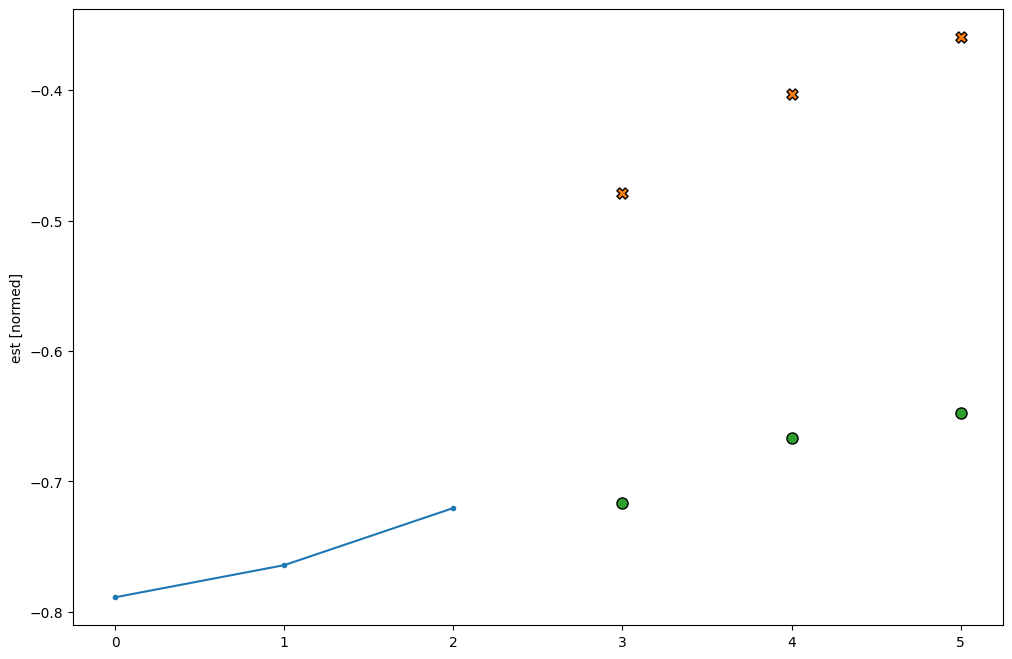

In [269]:
auto_wide_plot_model(feedback_model, multi_wide_long_data_train_by_zc_tf, multi_window, 0)